In [ ]:
# This is a notebook to show some simple regression algorithms and metrics. 

#Author: Viviana Acquaviva

#License: BSD but really should be TBD - just be nice.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import time
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

#Just to make our life easier!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

### Regression problems: in which we'd like to predict a continuous quantity, not a class.

To make our life simple, we will recycle one of our previous problems (the LAE vs OII classification) and re-cast it as a regression problem. Obviously it's not the best example, we will see another one later. 

In [7]:
data = pd.read_csv('LAE_OII_CCA.txt', sep = '\t', comment = '#')
data.columns =['type', 'wavelength', 'ELflux', 'continuum', 'EW']
seldata = data[(np.abs(stats.zscore(data.drop(['type'],axis=1))) < 3).all(axis=1)]
le = LabelEncoder()
newcol = le.fit_transform(seldata.type.values)
seldata.ix[:,'type'] = newcol
X, y = seldata.drop('type',axis=1), seldata.type
normalized_X = (X - X.mean())/X.std()

In [8]:
normalized_X.head()

,wavelength,ELflux,continuum,EW
0,0.886423,0.073902,-0.182579,-0.178461
1,-1.289933,-0.285972,-0.189455,-0.144318
2,-0.465461,-0.281563,-0.188735,-0.168591
3,-1.007104,-0.168740,-0.191117,1.499760
4,-0.539281,-0.254675,-0.182347,-0.223865


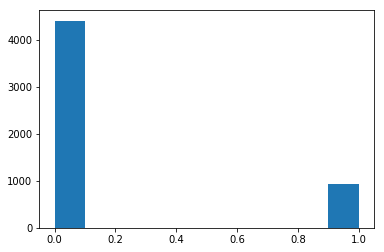

In [9]:
plt.hist(y);

### Q: What is the main implementation difference between classification and regression problems?

We need new scorers!

















In [10]:
#This line shows all the possible scoring functions accepted by sklearn.

sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

Let's build a regression model using Random Forests, picking a scoring parameter from the list above.

In [14]:
model = RandomForestRegressor()

cross_val_score(model, normalized_X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True),\
               scoring = 'neg_mean_absolute_error')


array([-0.07043966, -0.07259121, -0.06844569, -0.06938202, -0.06367041])

Another one that is used often is the 'r2' score. It's often called the coefficient of determination, usually denoted as R². It represents the proportion of variance (of y) that has been explained by the predictions. It's read as a square but it can be negative if the model is worse than a predictor of the mean :/

It's defined as 

$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$

In [16]:
#### Fill fill fill
model = RandomForestRegressor()

cross_val_score(model, normalized_X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True),\
               scoring = 'r2').mean()




0.7209924714994971

Note: Even if 1 is the best value, the R2 score is not a percentage! So how can we understand how good the predictions are?

A good start is to visualize the predictions.

In [17]:
ypred = cross_val_predict(model, normalized_X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True))

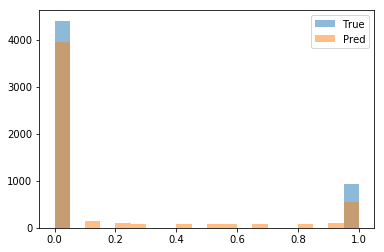

In [18]:
plt.hist(y, bins = 20, alpha = 0.5, label = 'True')
plt.hist(ypred, bins = 20, alpha = 0.5, label = 'Pred')
plt.legend();

We could also take a look at a scatter plot...

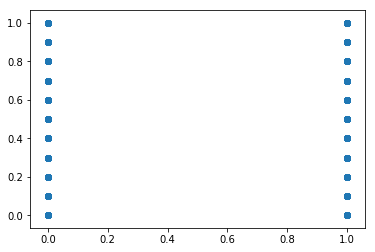

In [19]:
plt.scatter(y,ypred)

Let's see what this "regressor" is doing, e.g. how the points with intermediate probability look like, in a 2D projection.

Text(0.5, 0, 'EW')

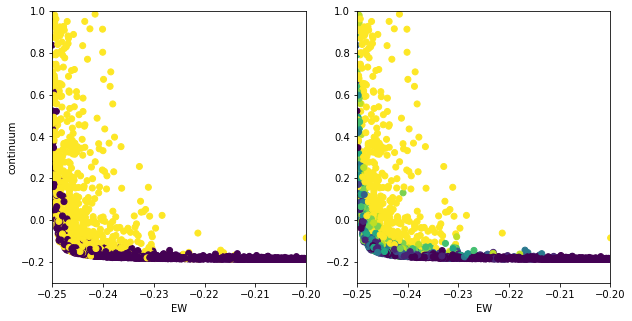

In [21]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.scatter(normalized_X['EW'], normalized_X['continuum'], c = y)
plt.xlim([-0.25,-0.2])
plt.ylim([-0.3,1])
plt.xlabel('EW')
plt.ylabel('continuum')

plt.subplot(1,2,2)

plt.scatter(normalized_X['EW'], normalized_X['continuum'], c = ypred)
plt.xlim([-0.25,-0.2])
plt.ylim([-0.3,1])
plt.xlabel('EW')

### Optimization

We already know how to play with parameters using Grid Search CV, so no big surprise here.

In [22]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We can do a little CV optimization, note that we have lost our class weight parameter though.

In [23]:
cvmethod = StratifiedKFold(n_splits=5, shuffle = True)

parameters = {'max_depth':[3,5,8], \
              'max_features': [2,4], 'n_estimators':[10,20,50]}

nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cvmethod, \
                     scoring = 'neg_mean_absolute_error', \
    verbose = 1, n_jobs = 4)
start = time.time()
model.fit(normalized_X, y)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    6.8s finished


Best params, best score: -0.0679 {'max_depth': 8, 'max_features': 4, 'n_estimators': 50}
Time per model (s): 0.0994


In [24]:
pd.options.display.max_colwidth = 100 

In [25]:
scores_df = pd.DataFrame(model.cv_results_)

In [27]:
scores_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [28]:
scores_df[['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
17,"{'max_depth': 8, 'max_features': 4, 'n_estimators': 50}",-0.067859,0.003090,-0.041775,0.374947
16,"{'max_depth': 8, 'max_features': 4, 'n_estimators': 20}",-0.068442,0.002499,-0.042279,0.166249
10,"{'max_depth': 5, 'max_features': 4, 'n_estimators': 20}",-0.068976,0.003060,-0.059106,0.169174
11,"{'max_depth': 5, 'max_features': 4, 'n_estimators': 50}",-0.069105,0.003059,-0.059011,0.362593
15,"{'max_depth': 8, 'max_features': 4, 'n_estimators': 10}",-0.069355,0.003189,-0.042725,0.082212
9,"{'max_depth': 5, 'max_features': 4, 'n_estimators': 10}",-0.069424,0.002759,-0.058964,0.073917
14,"{'max_depth': 8, 'max_features': 2, 'n_estimators': 50}",-0.069825,0.003485,-0.045487,0.258452
13,"{'max_depth': 8, 'max_features': 2, 'n_estimators': 20}",-0.070137,0.003125,-0.046128,0.105579
12,"{'max_depth': 8, 'max_features': 2, 'n_estimators': 10}",-0.070812,0.002605,-0.046570,0.056301
7,"{'max_depth': 5, 'max_features': 2, 'n_estimators': 20}",-0.072340,0.003018,-0.063959,0.106105


Let's discuss which parameters are best.

### What is best, classification or regression?

Many classification problems can be turned into regression problems. So, which one should we pick?

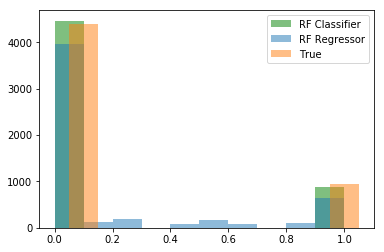

In [29]:
predicted_RFC = cross_val_predict(RandomForestClassifier(), normalized_X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True))

predicted_RFR = cross_val_predict(RandomForestRegressor(), normalized_X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True))

plt.hist(predicted_RFC,alpha = 0.5, color='green',label = 'RF Classifier')
plt.hist(predicted_RFR,alpha = 0.5, label = 'RF Regressor')
plt.hist(y+0.05,alpha = 0.5, label = 'True')

plt.legend();

Tricks: 

1) Look at input data, if they really look like classes then you should use a classifier.

2) You can't compute the accuracy if the target is continuous variable, but you can compute other metric scores if the target is a class! However I am not sure if this helps (see above).

In [31]:
print(metrics.r2_score(y, predicted_RFC))

print(metrics.r2_score(y, predicted_RFR))

0.6052535623993787
0.7238845737779784


### Last time, we saw that many classifiers also have a "predict.proba" method.

How does the above compare to the "predict.proba" property of classifiers?

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=5)

probas = RandomForestClassifier(n_estimators=20,max_depth=5).fit(Xtrain, ytrain).predict_proba(Xtest) #doing only on one fold

probas2 = RandomForestRegressor(n_estimators=20,max_depth=5).fit(Xtrain, ytrain).predict(Xtest)

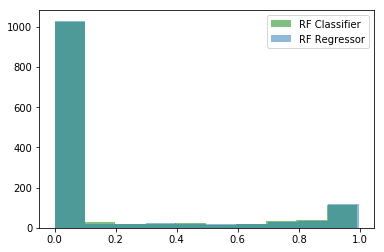

In [33]:
plt.hist(probas[:,1],alpha = 0.5, color='green',label = 'RF Classifier')
plt.hist(probas2,alpha = 0.5, label = 'RF Regressor')

plt.legend();

It looks like under the hood, classifiers with a "predict_proba" attribute are using a regression model to fit the probability that the object belongs to a given (positive for a binary classifier) class.

### How to estimate errors in ML regression predictions?

My answer: MonteCarlo. 

Let's have a simple example. We know that EW, continuum and emission line flux are not independent. So let's try to predict one from the other two.

In [34]:
features = normalized_X[['EW','continuum']]
target = normalized_X['ELflux'].values

In [35]:
features.shape

(5342, 2)

In [36]:
target

array([ 0.07390179, -0.28597194, -0.2815631 , ...,  2.60593664,
       -0.11177931, -0.25381976])

In [38]:
model = RandomForestRegressor()

ypred = cross_val_predict(model, features, target)

Let's look at a couple of evaluation metrics, and also make a scatter plot.

In [39]:
metrics.mean_absolute_error(target, ypred)

0.045959553644928694

In [40]:
metrics.r2_score(target, ypred)

0.9665869662905631

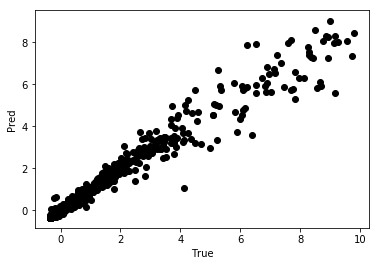

In [44]:
plt.scatter(target, ypred, color = 'k')
plt.xlabel('True')
plt.ylabel('Pred');

We can build e.g. 10 new samples where each point is randomly scattered by an amount proprtional to it observational arror (here 1%).

In [56]:
MC_pred = np.empty((len(target),20))

for i in range(20):
    newEW = features.EW + np.random.normal(0, np.abs(0.01*features.EW)) 
    newcont = features.continuum + np.random.normal(0, np.abs(0.01*features.continuum)) 
    feat = np.vstack([newEW,newcont]).T
    MC_pred[:,i] = cross_val_predict(model, feat, target)

In [46]:
#This prints the prediction + its standard deviation, which can be used as proxy for uncertainty

for i in range(len(target)):
    print('%.3f \t %.3f \t %.3f' % (target[i], ypred[i], MC_pred[i,:].std()))

0.074 	 0.085 	 0.079
-0.286 	 -0.295 	 0.041
-0.282 	 -0.281 	 0.033
-0.169 	 -0.211 	 0.025
-0.255 	 -0.270 	 0.046
1.380 	 1.341 	 0.253
4.047 	 3.907 	 1.472
8.417 	 7.274 	 1.909
-0.165 	 -0.147 	 0.050
-0.212 	 -0.240 	 0.020
-0.018 	 -0.082 	 0.132
-0.310 	 -0.298 	 0.036
-0.334 	 -0.316 	 0.061
-0.255 	 -0.254 	 0.053
-0.273 	 -0.264 	 0.029
-0.325 	 -0.326 	 0.034
-0.330 	 -0.333 	 0.067
-0.286 	 -0.290 	 0.028
-0.162 	 -0.131 	 0.066
-0.268 	 -0.280 	 0.036
-0.339 	 -0.330 	 0.051
0.509 	 0.341 	 0.050
-0.273 	 -0.248 	 0.033
-0.330 	 -0.307 	 0.011
-0.323 	 -0.328 	 0.050
-0.323 	 -0.318 	 0.029
-0.288 	 -0.277 	 0.132
-0.310 	 -0.291 	 0.059
-0.335 	 -0.334 	 0.029
-0.293 	 -0.283 	 0.022
-0.321 	 -0.327 	 0.032
-0.123 	 -0.105 	 0.093
-0.344 	 -0.321 	 0.025
-0.337 	 -0.319 	 0.039
-0.278 	 -0.289 	 0.017
-0.221 	 -0.199 	 0.101
-0.191 	 -0.195 	 0.050
-0.302 	 -0.314 	 0.030
-0.307 	 -0.305 	 0.035
-0.142 	 0.619 	 0.917
-0.330 	 -0.326 	 0.059
5.784 	 6.067 	 1.713
-0.30

-0.296 	 -0.296 	 0.029
-0.045 	 -0.087 	 0.076
0.263 	 0.432 	 0.883
-0.316 	 -0.319 	 0.026
-0.155 	 -0.190 	 0.080
-0.269 	 -0.245 	 0.030
-0.293 	 -0.293 	 0.036
-0.269 	 -0.287 	 0.029
-0.315 	 -0.310 	 0.032
-0.269 	 -0.257 	 0.041
-0.248 	 -0.257 	 0.052
7.695 	 8.133 	 1.354
0.185 	 0.145 	 0.095
-0.201 	 -0.226 	 0.040
-0.287 	 -0.301 	 0.038
0.025 	 0.029 	 0.071
3.060 	 2.756 	 0.247
-0.178 	 -0.161 	 0.054
-0.291 	 -0.300 	 0.053
-0.239 	 -0.225 	 0.072
-0.301 	 -0.309 	 0.071
-0.283 	 -0.295 	 0.028
-0.250 	 -0.271 	 0.049
-0.144 	 -0.130 	 0.060
0.168 	 0.167 	 0.046
-0.064 	 -0.042 	 0.066
-0.318 	 -0.299 	 0.022
-0.181 	 -0.148 	 0.060
-0.117 	 -0.065 	 0.627
-0.191 	 -0.206 	 0.030
-0.271 	 -0.252 	 0.027
-0.184 	 -0.200 	 0.057
-0.191 	 -0.172 	 0.079
-0.274 	 -0.274 	 0.067
-0.154 	 -0.149 	 0.045
-0.273 	 -0.263 	 0.035
-0.305 	 -0.309 	 0.041
-0.309 	 -0.320 	 0.020
0.076 	 0.136 	 0.154
-0.305 	 -0.306 	 0.036
-0.316 	 -0.306 	 0.034
-0.208 	 -0.176 	 0.094
-0.086

-0.262 	 -0.259 	 0.109
-0.061 	 -0.023 	 0.136
-0.299 	 -0.280 	 0.041
0.298 	 0.225 	 0.117
-0.226 	 -0.255 	 0.050
-0.097 	 -0.121 	 0.076
-0.314 	 -0.331 	 0.032
0.608 	 0.676 	 0.140
-0.244 	 -0.267 	 0.096
-0.048 	 -0.079 	 0.078
0.389 	 0.314 	 0.196
-0.289 	 -0.285 	 0.028
-0.325 	 -0.316 	 0.025
-0.304 	 -0.305 	 0.018
-0.261 	 -0.240 	 0.041
-0.322 	 -0.312 	 0.024
-0.325 	 -0.316 	 0.036
-0.199 	 -0.186 	 0.052
-0.342 	 -0.332 	 0.041
-0.083 	 -0.096 	 0.076
-0.309 	 -0.327 	 0.037
-0.315 	 -0.330 	 0.036
-0.214 	 -0.225 	 0.054
-0.306 	 -0.297 	 0.091
0.569 	 0.324 	 0.118
-0.251 	 -0.300 	 0.037
-0.240 	 -0.246 	 0.034
-0.339 	 -0.332 	 0.060
-0.339 	 -0.332 	 0.016
-0.305 	 -0.306 	 0.074
-0.258 	 -0.212 	 0.146
-0.043 	 -0.081 	 0.065
-0.345 	 -0.332 	 0.022
-0.335 	 -0.322 	 0.062
-0.292 	 -0.281 	 0.025
-0.272 	 -0.276 	 0.020
-0.286 	 -0.305 	 0.025
-0.332 	 -0.308 	 0.019
0.494 	 0.622 	 0.315
-0.149 	 -0.165 	 0.056
-0.165 	 -0.140 	 0.056
-0.321 	 -0.326 	 0.039
0.

-0.235 	 -0.250 	 0.051
-0.230 	 -0.228 	 0.035
2.300 	 2.265 	 0.620
-0.106 	 -0.138 	 0.144
-0.315 	 -0.302 	 0.061
0.712 	 0.876 	 1.269
-0.308 	 -0.299 	 0.072
0.197 	 0.167 	 0.284
-0.297 	 -0.291 	 0.062
-0.319 	 -0.301 	 0.025
-0.049 	 -0.093 	 0.069
-0.281 	 -0.286 	 0.050
-0.252 	 -0.266 	 0.033
-0.237 	 -0.235 	 0.036
-0.042 	 -0.061 	 0.032
2.707 	 3.398 	 1.496
1.394 	 1.434 	 0.460
-0.196 	 -0.194 	 0.051
-0.217 	 -0.245 	 0.023
-0.242 	 -0.207 	 0.041
-0.167 	 -0.165 	 0.079
-0.210 	 -0.201 	 0.044
-0.269 	 -0.271 	 0.046
-0.289 	 -0.293 	 0.059
-0.208 	 -0.212 	 0.156
-0.309 	 -0.319 	 0.034
-0.287 	 -0.301 	 0.037
-0.296 	 -0.302 	 0.040
-0.283 	 -0.278 	 0.023
-0.289 	 -0.287 	 0.072
-0.260 	 -0.249 	 0.046
-0.270 	 -0.272 	 0.092
-0.258 	 -0.243 	 0.041
-0.118 	 -0.110 	 0.087
-0.225 	 -0.243 	 0.060
0.812 	 0.443 	 0.293
-0.187 	 -0.197 	 0.086
-0.183 	 -0.149 	 0.043
-0.220 	 -0.238 	 0.055
-0.093 	 -0.136 	 0.081
-0.283 	 -0.289 	 0.118
-0.329 	 -0.319 	 0.039
-0.3

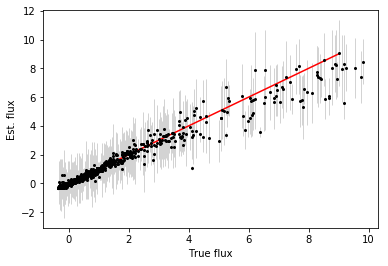

In [57]:
#And finally, we can make a scatter plot with error bars.

plt.errorbar(target, ypred, yerr=MC_pred.std(axis = 1), fmt='o', markersize = 2, c= 'k',ecolor='lightgray', elinewidth=1)
plt.plot(np.arange(10),np.arange(10),c='r')
plt.xlabel('True flux');
plt.ylabel('Est. flux');

### Summary

- In regression problems, we predict quantities and not classes.

- We can use the same algorithms, but the evaluation metric changes and is typically a tracer of how close we are to the true values.

- We also saw how we can use Monte Carlo to include individual errors in our predictions.

Further reading: For a complete worked example you can see the "mass-luminosity-color-metallicity" notebook at

https://github.com/vacquaviva/Metallicity_Estimation